# Ground Projection

In [1]:
import os
import cv2
import numpy as np

from dt_computer_vision.camera import CameraModel
from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

# TODO: update the dimensions of the board once new pattern is finalized
board.square_size = 0.020
board.x_offset = 0.216
board.y_offset = -0.077

# Load camera model from YAML file
yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario1",
    "calibration-intrinsic-dd24.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    camera = CameraModel.from_ros_calibration(yaml_content)

print(camera)

assert image.shape == (camera.height, camera.width, 3), f"Image shape: {image.shape}, Camera shape: {*camera.get_shape(), 3}"

CameraModel(width=240, height=320, K=array([[154.58959978,   0.        , 110.33748015],
       [  0.        , 154.94617019, 161.1407896 ],
       [  0.        ,   0.        ,   1.        ]]), D=array([-0.35435176,  0.16442206,  0.00194067, -0.00289178, -0.04067351]), P=array([[154.58959978,   0.        , 110.33748015,   0.        ],
       [  0.        , 154.94617019, 161.1407896 ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]]), R=array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]), H=None, rectifier=<dt_computer_vision.camera.types.Rectifier object at 0x7841d668be80>)


In [2]:
# Modify the camera's homography to project points
# to a plane parallel to the ground but 1m below it


# Load ground homography from YAML file
import os
import yaml

from dt_computer_vision.camera.homography import ResolutionIndependentHomography
import numpy as np

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")

yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario1",
    "homography.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    homography = yaml.safe_load(yaml_content)
    
H : ResolutionIndependentHomography = ResolutionIndependentHomography.read(np.array(homography["homography"]).reshape(3, 3))

print(H)

[[ 5.45342113e-03  4.45997812e-02  1.75576545e-01]
 [-7.86773736e-02  3.58108785e-04  2.04818051e-03]
 [ 2.35097451e-02  8.68776142e-01  1.00000000e+00]]


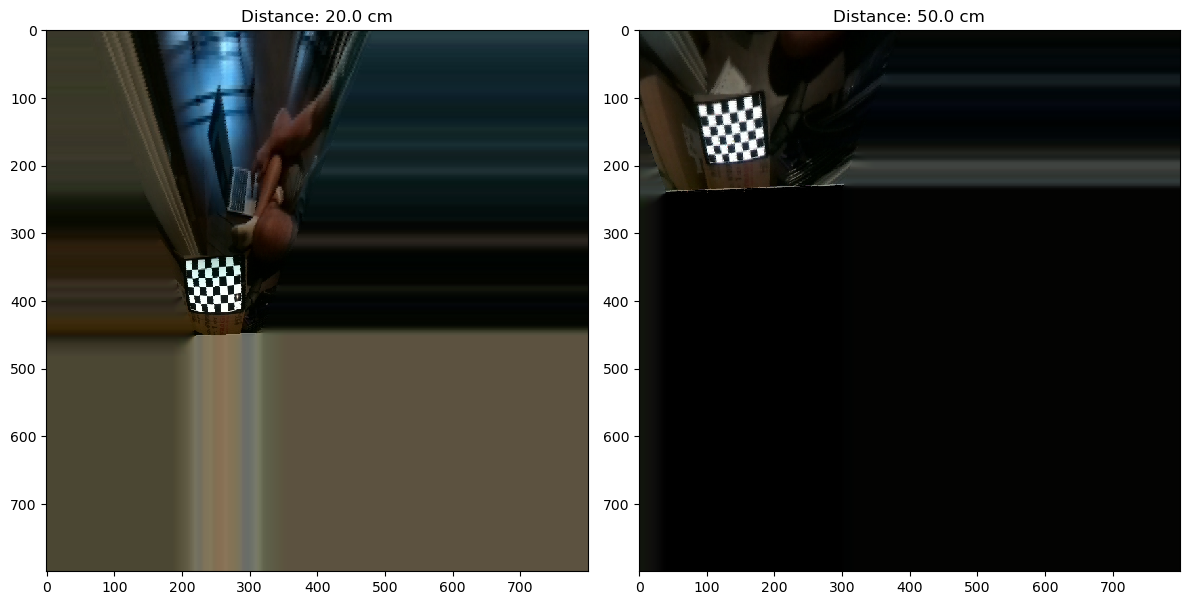

In [3]:
from typing import List, Tuple
from dt_computer_vision.camera.types import Point, Size, RegionOfInterest
from dt_computer_vision.camera.calibration.extrinsics.chessboard import compute_homography_maps
from dt_computer_vision.ground_projection.ground_projector import GroundProjector

import matplotlib.pyplot as plt


image_fpaths = [
    os.path.join(assets_dir, f"extrinsics/dd24/real-world/scenario1/{distance}cm.png") for distance in [20, 50]
    ]

fig, axs = plt.subplots(1, len(image_fpaths), figsize=(12, 8))

for type, image_fpath in enumerate(image_fpaths):
    distance = float(image_fpath.split('/')[-1].split('cm')[0])
    
    # Read the image
    image = cv2.imread(image_fpath)

    # Modify the camera's homography to account for the height of the drone
    H_inv = np.linalg.inv(H.camera_specific(camera))
    H_inv += distance * 1e-3 * np.array([[0, 0, camera.cx], [0, 0, camera.cy], [0, 0, 1]])
    H_floor = np.linalg.inv(H_inv)

    ppm: int = 800

    roi: RegionOfInterest = RegionOfInterest(origin=Point(board.x_offset, board.y_offset), size=Size(1, 1))

    mapx, mapy, mask, shape = compute_homography_maps(camera, H_floor, ppm, roi)

    img = cv2.remap(image, mapx, mapy, cv2.INTER_CUBIC)
    img = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)

    # flip and rotate the image so that it appears as it is seen from the camera
    img = cv2.flip(img, 0)
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot the image in the corresponding subplot
    axs[type].imshow(img)
    axs[type].set_title(f"Distance: {distance} cm")

# Remove empty subplots
for type in range(6, len(axs.flat)):
    axs.flat[type].axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Show the tiled images
plt.show()

Found 35 corners.
Found 35 corners.


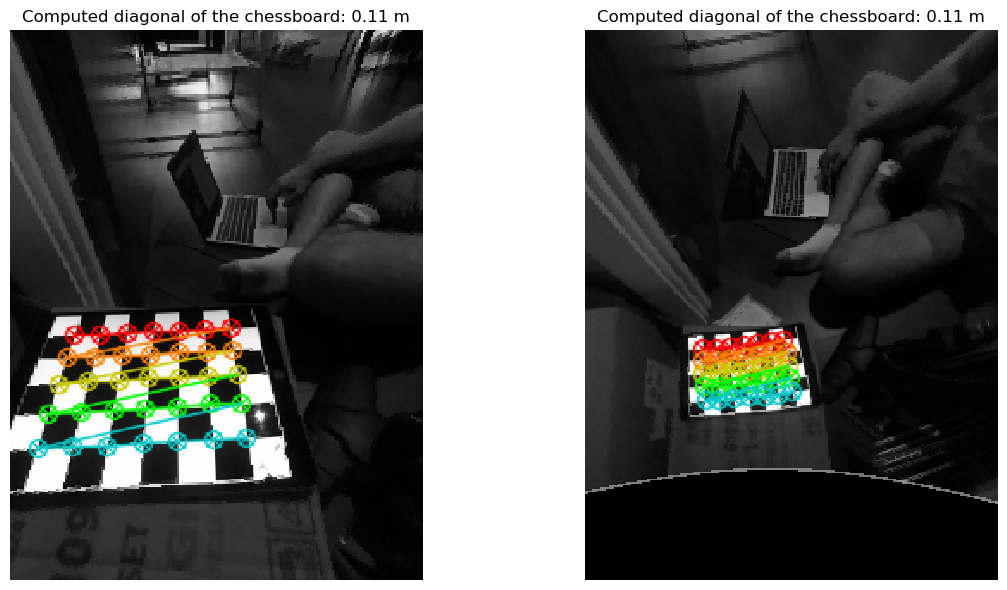

In [4]:
import cv2

import matplotlib.pyplot as plt

from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.types import Pixel

# Define the number of rows and columns for the tiled plot
num_rows = 1
num_cols = len(image_fpaths)

board = CalibrationBoard8by6

# Create a new figure with the specified number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Iterate over the rectified images and plot them in the tiled subplots
for type, image_fpath in enumerate(image_fpaths):
    image = cv2.imread(image_fpath)

    distance = float(image_fpath.split('/')[-1].split('cm')[0])

    # Modify the camera's homography to account for the height of the drone
    H_inv = np.linalg.inv(H.camera_specific(camera))
    H_inv += distance * 1e-3 * np.array([[0, 0, camera.cx], [0, 0, camera.cy], [0, 0, 1]])
    H_floor = np.linalg.inv(H_inv)

    camera.H = H_floor

    projector = GroundProjector(camera)

    # rectify image
    image = camera.rectifier.rectify(image)
    rectified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Find corners of the board
    corners: List[Pixel] = find_corners(image, board)
    print(f"Found {len(corners)} corners.")
    assert len(corners) == (board.columns - 1) * (board.rows - 1)
    
    # draw detected corners on top of the image
    image_w_corners = draw_corners(image, board, corners)
    image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)

    # Project the upper left and bottom right corners to the ground and compute their euclidean distance
    upper_left = projector.vector2ground(camera.pixel2vector(corners[0]))
    bottom_right = projector.vector2ground(camera.pixel2vector(corners[-1]))
    
    # Compute their distance
    diagonal = np.linalg.norm(np.array(upper_left.as_array()) - np.array(bottom_right.as_array()))

    # Plot the rectified image in the corresponding subplot
    axs[type].imshow(image_w_corners_rgb)
    axs[type].set_title(f"Computed diagonal of the chessboard: {diagonal:.2f} m")
    axs[type].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the tiled plot of rectified images
plt.show()

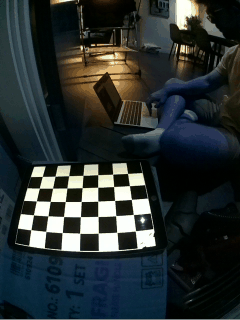

In [5]:
import cv2
import numpy as np
import imageio

# Load the image
image_fpath = image_fpaths[0]
image = cv2.imread(image_fpath)

# Get the image width and height
height, width = image.shape[:2]

# Define the translation amount
translation_amount = int(width / 2)
translation_time = 3 # seconds

# Create a black image with the same size as the original image
black_image = np.zeros_like(image)

# Generate the sequence of translated images
sequence = []
for type in range(30):
    # Calculate the translation amount for the current frame
    translation = int((type / 30) * translation_amount)
    
    # Create a translation matrix
    M = np.float32([[1, 0, translation], [0, 1, 0]])
    
    # Apply the translation to the original image
    translated_image = cv2.warpAffine(image, M, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    
    # Combine the translated image with the black image to fill the missing pixels
    final_image = cv2.bitwise_or(translated_image, black_image)
    
    # Add the final image to the sequence
    sequence.append(final_image)

import imageio
from IPython.display import Image, display
import io

# Create an in-memory bytes buffer
buffer = io.BytesIO()

# Save the animation to the buffer
imageio.mimsave(buffer, sequence, format='GIF', duration=translation_time / len(sequence))

# Move the cursor of the buffer to the start
buffer.seek(0)

# Display the gif
display(Image(data=buffer.read(), format='png'))


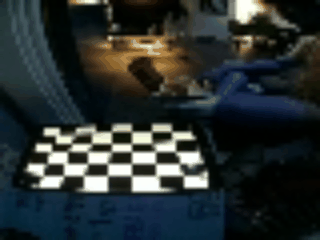

In [6]:
import cv2

# Compute optical flow using the OpticalFlow class
from dt_computer_vision.optical_flow.optical_flow import OpticalFlow


config = {
    "process_frequency": 20,
    "track_len": 10,
    "detect_interval": 5,
    "img_scale": 0.25
}

VIS_SCALE = int(1/config["img_scale"])

# Create an instance of the OpticalFlow class
optical_flow = OpticalFlow(
    track_len=config["track_len"],
    detect_interval=config["detect_interval"],
    resize_scale=config["img_scale"],
)

SEQUENCE_FRAME_COUNT = len(sequence)
delta_t = translation_time / SEQUENCE_FRAME_COUNT

debug_images = []
debug_strs = []
disp_vectors = []
vel_vectors = []
features_locations = []

# Iterate over sequence picking two consecutive frames
for image in sequence:
    # Compute the optical flow
    displacements_array, velocities_arr, locations, vis, debug_str = optical_flow.compute_motion_vectors(image, delta_t, debug_viz_on=True)
    
    # Scale up the image
    debug_image = cv2.resize(vis, (vis.shape[1]*VIS_SCALE, vis.shape[0]*VIS_SCALE))

    # Embed debug string in the debug image
    cv2.putText(debug_image, debug_str, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    debug_images.append(debug_image)
    features_locations.append(locations)
    disp_vectors.append(displacements_array)
    vel_vectors.append(velocities_arr)
    debug_strs.append(debug_str)

# Display the optical flow

import imageio
from IPython.display import Image, display
import io

# Create an in-memory bytes buffer
buffer = io.BytesIO()

# Save the animation to the buffer
imageio.mimsave(buffer, debug_images, format='GIF', duration=translation_time / len(sequence))

# Move the cursor of the buffer to the start
buffer.seek(0)

# Display the gif
display(Image(data=buffer.read(), format='png'))


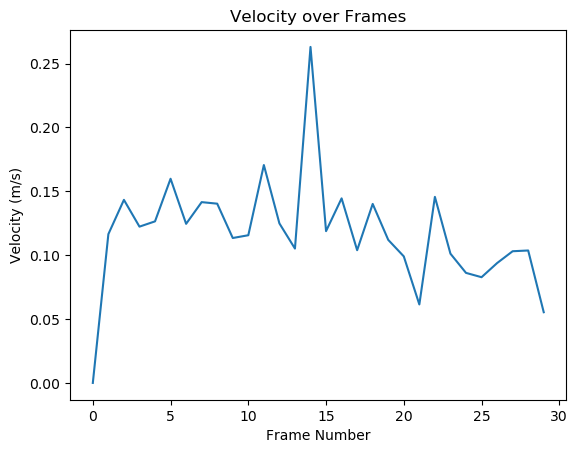

In [7]:
distance = float(image_fpath.split('/')[-1].split('cm')[0])

assert len(disp_vectors) == len(vel_vectors) == len(features_locations) == SEQUENCE_FRAME_COUNT

velocities = []
displacement_vectors = []

# Iterate over each frame
for frame, (vel_vec_field, locations) in enumerate(zip(vel_vectors, features_locations)):
    velocities.append(
        optical_flow.compute_velocity_vector(vel_vec_field, locations, projector, camera)
        )

assert velocities[0].shape == (2,)
assert len(velocities) == SEQUENCE_FRAME_COUNT, f"Expected {SEQUENCE_FRAME_COUNT} displacement vectors, got {len(velocities)}"

# Generate a line plot to display the velocity over each frame
frame_numbers = list(range(len(velocities)))
velocities = [np.linalg.norm(vel) for vel in velocities]

plt.plot(frame_numbers, velocities)
plt.xlabel('Frame Number')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity over Frames')
plt.show()